In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://query.data.world/s/gl4ldmqj3t5h25s5f6lhgsj6kfkfr6?dws=00000", parse_dates={"date":["YEAR", "MONTH"]})
df["date"] = df["date"].dt.to_period("M")   # On a pas d'informations sur le jour et l'heure, seulement sur l'année et le mois

In [3]:
df.head()

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
0,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AEX,"Alexandria, LA",LA,Louisiana,US,United States
1,2015-04,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AFW,"Dallas/Fort Worth, TX",TX,Texas,US,United States
2,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,ATL,"Atlanta, GA",GA,Georgia,US,United States
3,2015-01,89,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia
4,2015-03,108,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia


<AxesSubplot:title={'center':'Nombre de passagers mensuel ayant pour destination FR'}, xlabel='Date (mois et année)', ylabel='Nombre de passagers'>

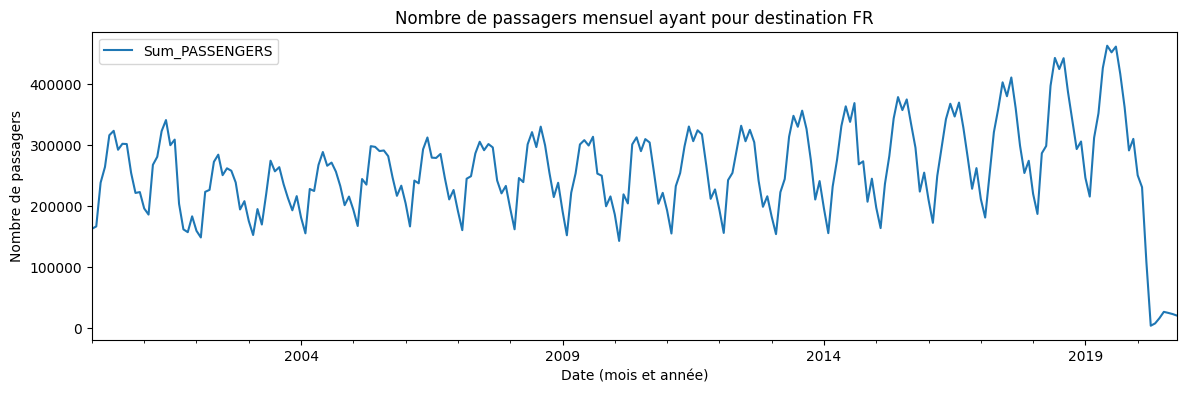

In [34]:
# Nombre de passagers allant dans un pays chaque mois
country_code = "FR"
data = df[df["DEST_COUNTRY"]==country_code][["date", "Sum_PASSENGERS"]].groupby("date").sum()
data.plot(title=f"Nombre de passagers mensuel ayant pour destination {country_code}",
          xlabel="Date (mois et année)",
          ylabel="Nombre de passagers",
          figsize=(14,4))